In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import seaborn as sns
import os
sns.set_style("whitegrid")
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense


In [9]:
# base_dir = 'd:/GitHub/python-2-work/' # work
base_dir = 'd:/_SRC_/ensemble-forecasting/' # home
h = np.loadtxt(base_dir + 'data/2011/2011080100_hiromb_GI_60x434.txt') - 37.356
s = np.loadtxt(base_dir + 'data/2011/2011080100_swan_GI_48x434.txt')
n = np.loadtxt(base_dir + 'data/2011/2011080100_noswan_GI_48x434.txt')
m = np.loadtxt(base_dir + 'data/2011/2011080100_measurements_GI_2623.txt')

# forecast dimensions
N = 430
T = 48

# preparing measurements forecast
m_fc = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        m_fc[i, j] = m[i*6+j]

# data cut and shifting
shift_const = 0
h = h[0:N, 1:T+1] + shift_const
s = s[0:N, 1:T+1] + shift_const
n = n[0:N, 1:T+1] + shift_const
m_fc = m_fc[0:N, 1:T+1] + shift_const
h.shape, s.shape, n.shape, m_fc.shape


((430, 48), (430, 48), (430, 48), (430, 48))

In [11]:
a = opt.minimize(lambda a: np.mean(np.abs(a[0] + a[1]*h + a[2]*s - m_fc)), 
                 [0, 0.5, 0.5]).x
ens = a[0] + a[1]*h + a[2]*s        
                 
def plot_ensemble(q):
    plt.figure()
    plt.plot(h[q], 'r-')
    plt.plot(s[q], 'g-')
    plt.plot(m_fc[q], 'ko')
    plt.plot(ens[q], 'm-', linewidth=2)
    plt.title('h:{0:.2f} s:{1:.2f} ens:{2:.2f}'.format(np.mean(np.abs(h[q] - m_fc[q])),
              np.mean(np.abs(s[q] - m_fc[q])), 
              np.mean(np.abs(ens[q] - m_fc[q]))))

a


array([ 2.96448653,  0.63595456,  0.4027131 ])

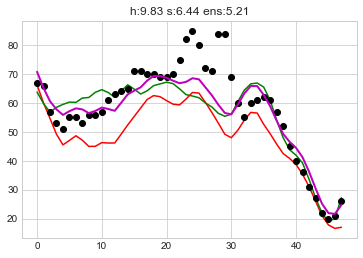

In [20]:
plot_ensemble(230)




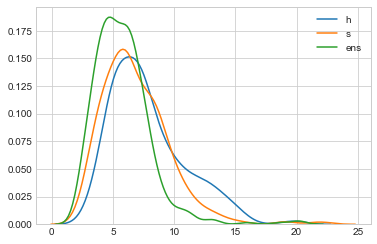

In [14]:
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')


In [19]:
model = Sequential()
model.add(Dense(units=3, activation='sigmoid', input_dim=2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss=keras.losses.mean_squared_error, optimizer='sgd', metrics=['accuracy'])
model.fit(np.vstack((h.flatten(),s.flatten())).transpose(), m_fc.flatten())


Epoch 1/1


   32/20640 [..............................] - ETA: 5:58 - loss: 1183.5178 - acc: 0.0625

  704/20640 [>.............................] - ETA: 17s - loss: 1624.0563 - acc: 0.0085 

 1472/20640 [=>............................] - ETA: 8s - loss: 1638.0042 - acc: 0.0088 

 2240/20640 [==>...........................] - ETA: 5s - loss: 1657.4016 - acc: 0.0103



 2944/20640 [===>..........................] - ETA: 4s - loss: 1684.6146 - acc: 0.0092

 3616/20640 [====>.........................] - ETA: 3s - loss: 1698.5433 - acc: 0.0097

 4320/20640 [=====>........................] - ETA: 3s - loss: 1699.8333 - acc: 0.0093

 5152/20640 [======>.......................] - ETA: 2s - loss: 1687.7549 - acc: 0.0099



 5728/20640 [=======>......................] - ETA: 2s - loss: 1689.1874 - acc: 0.0094

 6240/20640 [========>.....................] - ETA: 2s - loss: 1695.4873 - acc: 0.0091

 6656/20640 [========>.....................] - ETA: 2s - loss: 1689.6711 - acc: 0.0092

 7328/20640 [=========>....................] - ETA: 2s - loss: 1701.5413 - acc: 0.0089



 8064/20640 [==========>...................] - ETA: 1s - loss: 1705.2401 - acc: 0.0091

 8576/20640 [===========>..................] - ETA: 1s - loss: 1708.9855 - acc: 0.0087

 9408/20640 [============>.................] - ETA: 1s - loss: 1710.8204 - acc: 0.0087

10016/20640 [=============>................] - ETA: 1s - loss: 1709.9105 - acc: 0.0086

10720/20640 [==============>...............] - ETA: 1s - loss: 1714.1439 - acc: 0.0082

11136/20640 [===============>..............] - ETA: 1s - loss: 1715.0900 - acc: 0.0082

11872/20640 [================>.............] - ETA: 1s - loss: 1716.2798 - acc: 0.0078



12608/20640 [=================>............] - ETA: 1s - loss: 1718.6025 - acc: 0.0076



13120/20640 [==================>...........] - ETA: 0s - loss: 1726.5447 - acc: 0.0079



13216/20640 [==================>...........] - ETA: 0s - loss: 1728.2567 - acc: 0.0080

13856/20640 [===================>..........] - ETA: 0s - loss: 1724.4883 - acc: 0.0082

14496/20640 [====================>.........] - ETA: 0s - loss: 1719.7400 - acc: 0.0083

15136/20640 [=====================>........] - ETA: 0s - loss: 1722.4389 - acc: 0.0082

15584/20640 [=====================>........] - ETA: 0s - loss: 1723.0381 - acc: 0.0081

16032/20640 [======================>.......] - ETA: 0s - loss: 1721.4811 - acc: 0.0080

16576/20640 [=======================>......] - ETA: 0s - loss: 1721.5517 - acc: 0.0082

17280/20640 [========================>.....] - ETA: 0s - loss: 1722.7489 - acc: 0.0082

17600/20640 [========================>.....] - ETA: 0s - loss: 1721.7704 - acc: 0.0083

17952/20640 [=========================>....] - ETA: 0s - loss: 1718.6077 - acc: 0.0084

18656/20640 [==========================>...] - ETA: 0s - loss: 1717.2946 - acc: 0.0085

18976/20640 [==========================>...] - ETA: 0s - loss: 1715.9041 - acc: 0.0085

19360/20640 [===========================>..] - ETA: 0s - loss: 1713.8646 - acc: 0.0086

20160/20640 [============================>.] - ETA: 0s - loss: 1714.4160 - acc: 0.0086



20640/20640 [==============================] - 3s 121us/step - loss: 1716.1828 - acc: 0.0086


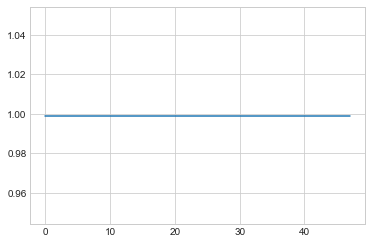

In [28]:
# [model.predict([h[230, tt], s[230,tt]]) for tt in range(T)]
plt.plot(model.predict(np.array([h[230], s[230]]).transpose()))






